In [ ]:
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

ALGORITHMS = [
    "prime256v1",       # Klassisch (ECDH)
    "mlkem512",         # PQC Level 1
    "mlkem768",         # PQC Level 3
    "mlkem1024",        # PQC Level 5
    "X25519MLKEM768"    # Hybrid
]

LATENCIES = [0, 50, 100] 
ITERATIONS = 5

In [ ]:
def install_traffic_control():
    """Installiert tc im Container falls nötig"""
    check = subprocess.run("docker exec pqc-client tc -V", shell=True, capture_output=True)
    if check.returncode != 0:
        subprocess.run("docker exec pqc-client apk update && docker exec pqc-client apk add iproute2", shell=True, stdout=subprocess.DEVNULL)

def set_latency(latency_ms):
    """Setzt die Latenz im Client-Container"""
    subprocess.run("docker exec pqc-client tc qdisc del dev eth0 root", shell=True, stderr=subprocess.DEVNULL)
    if latency_ms > 0:
        cmd = f"docker exec pqc-client tc qdisc add dev eth0 root netem delay {latency_ms}ms"
        subprocess.run(cmd, shell=True)
        print(f"   -> Netzwerk-Latenz auf {latency_ms}ms gesetzt.")
    else:
        print(f"   -> Netzwerk-Latenz entfernt (Full Speed).")

def start_server(algo):
    subprocess.run("docker exec pqc-server pkill openssl", shell=True, stderr=subprocess.DEVNULL)
    time.sleep(1)
    # Server starten
    cmd = f"docker exec -d pqc-server openssl s_server -cert /certs/server.crt -key /certs/server.key -accept 4433 -www -groups {algo}"
    subprocess.run(cmd, shell=True)
    time.sleep(2)
    
def run_single_handshake(algo):
    cmd = f"echo Q | docker exec -i pqc-client openssl s_client -connect server:4433 -groups {algo} -CAfile /certs/CA.crt"
    
    start_time = time.perf_counter()
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    end_time = time.perf_counter()
    
    if result.returncode == 0 and "Verify return code: 0 (ok)" in result.stdout:
        return (end_time - start_time) * 1000
    else:
        return None

In [ ]:
install_traffic_control()

data = []

print("=== STARTE BENCHMARK ===")

try:
    for lat in LATENCIES:
        print(f"\nSzenario: {lat}ms Latenz")
        set_latency(lat)
        
        for algo in ALGORITHMS:
            print(f"  Test: {algo} ... ", end="")
            start_server(algo)
            
            run_single_handshake(algo)
            
            measurements = []
            for i in range(ITERATIONS):
                duration = run_single_handshake(algo)
                if duration:
                    measurements.append(duration)
                else:
                    print("x", end="")
            
            if measurements:
                avg = sum(measurements) / len(measurements)
                print(f"Ø {avg:.2f} ms")
                # Ergebnis speichern
                data.append({'Algorithm': algo, 'Latency_ms': lat, 'Handshake_Time_ms': avg})
            else:
                print("FAILED")

finally:
    subprocess.run("docker exec pqc-client tc qdisc del dev eth0 root", shell=True, stderr=subprocess.DEVNULL)
    subprocess.run("docker exec pqc-server pkill openssl", shell=True, stderr=subprocess.DEVNULL)

df = pd.DataFrame(data)
df.head(15)

=== STARTE BENCHMARK ===

Szenario: 0ms Latenz
   -> Netzwerk-Latenz entfernt (Full Speed).
  Test: prime256v1 ... Ø 30.62 ms
  Test: mlkem512 ... Ø 29.34 ms
  Test: mlkem768 ... Ø 29.23 ms
  Test: mlkem1024 ... Ø 28.97 ms
  Test: X25519MLKEM768 ... Ø 29.10 ms

Szenario: 50ms Latenz
   -> Netzwerk-Latenz auf 50ms gesetzt.
  Test: prime256v1 ... Ø 181.54 ms
  Test: mlkem512 ... Ø 181.35 ms
  Test: mlkem768 ... Ø 181.33 ms
  Test: mlkem1024 ... Ø 181.15 ms
  Test: X25519MLKEM768 ... Ø 181.46 ms

Szenario: 100ms Latenz
   -> Netzwerk-Latenz auf 100ms gesetzt.
  Test: prime256v1 ... Ø 331.71 ms
  Test: mlkem512 ... Ø 331.51 ms
  Test: mlkem768 ... Ø 331.83 ms
  Test: mlkem1024 ... Ø 331.33 ms
  Test: X25519MLKEM768 ... Ø 331.66 ms

Räume auf...


,Algorithm,Latency_ms,Handshake_Time_ms
0,prime256v1,0,30.622942
1,mlkem512,0,29.338456
2,mlkem768,0,29.225637
3,mlkem1024,0,28.966387
4,X25519MLKEM768,0,29.103554
5,prime256v1,50,181.535782
6,mlkem512,50,181.349004
7,mlkem768,50,181.325957
8,mlkem1024,50,181.147674
9,X25519MLKEM768,50,181.458821


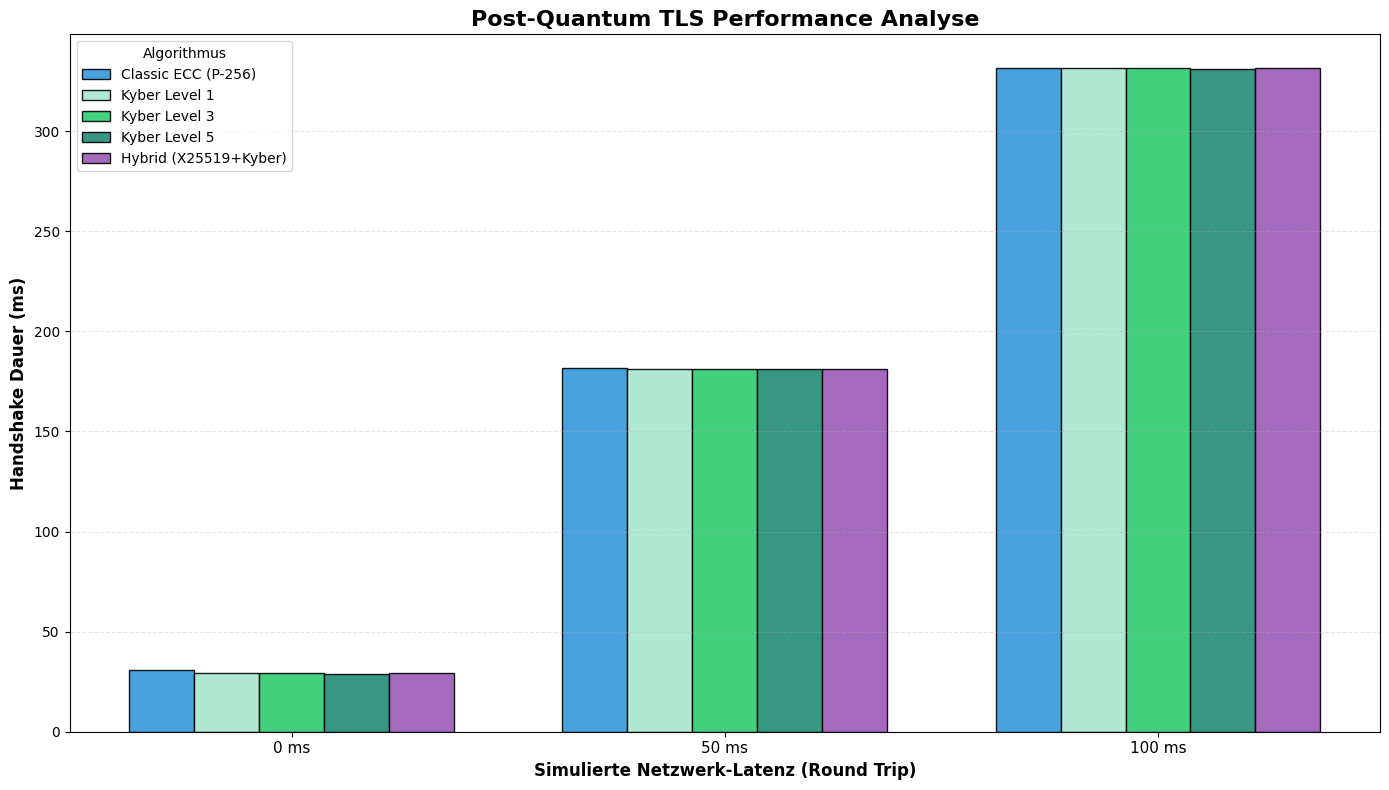

In [ ]:
# Setup
algorithms = df['Algorithm'].unique()
latencies = df['Latency_ms'].unique()
x = np.arange(len(latencies))
width = 0.15 

fig, ax = plt.subplots(figsize=(14, 8))

colors = {
    'prime256v1': '#3498db',
    'mlkem512': '#a8e6cf',
    'mlkem768': '#2ecc71',
    'mlkem1024': '#218c74',
    'X25519MLKEM768': '#9b59b6'
}

nice_names = {
    'prime256v1': 'Classic ECC (P-256)',
    'mlkem512': 'Kyber Level 1',
    'mlkem768': 'Kyber Level 3',
    'mlkem1024': 'Kyber Level 5',
    'X25519MLKEM768': 'Hybrid (X25519+Kyber)'
}

for i, algo in enumerate(algorithms):
    subset = df[df['Algorithm'] == algo].sort_values('Latency_ms')
    times = subset['Handshake_Time_ms'].values
    
    position = x + (i * width) - (len(algorithms) * width / 2) + (width / 2)
    
    rects = ax.bar(position, times, width, 
                   label=nice_names.get(algo, algo), 
                   color=colors.get(algo, 'gray'), 
                   edgecolor='black', alpha=0.9)

ax.set_ylabel('Handshake Dauer (ms)', fontsize=12, fontweight='bold')
ax.set_xlabel('Simulierte Netzwerk-Latenz (Round Trip)', fontsize=12, fontweight='bold')
ax.set_title('Post-Quantum TLS Performance Analyse', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{l} ms" for l in latencies], fontsize=11)
ax.legend(title="Algorithmus", loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()